<table>
  <tr>
    <td><div align="left"><font size="30" >Practical 05 - Computer Vision</font></div></td>
  </tr>
</table>

We would like to thank Peter Corke. The notebook was adapted from P. Corke's RVSS Tutorial material. 

<table>
  <tr>
    <td><div align="left"><font size="20" >Homogeneous Coordinates</font></div></td>
  </tr>
</table>

We need to import some modules. We will use the standard `numpy` package to help us with linear algebraic operations on matrices and vectors.

If you want to know what a function does, just click somewhere within the parentheses that enclose the arguments and hit SHIFT+TAB. If there's a + button at the top of the popup tooltip, this means the documentation spans a few lines, click it to show the full docstring, then scroll up.

In [1]:
import numpy as np
import cv2
import sys
import os.path
import math
import pickle

sys.path.append("common") # common stuff

from common import *
from cam_visualizers import *

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Intersection of two lines in the Euclidean plane
Now consider two lines: $y = x-2$, and also $y = -2x+6$.
They can be represented in homogeneous form as 3-tuples
\begin{align}
\ell_1 &= \begin{pmatrix}1 & -1 & -2\end{pmatrix} \\
\ell_2 &= \begin{pmatrix}-2 & -1 & 6\end{pmatrix}
\end{align}
In python this is

In [2]:
l1 = np.array([1, -1, -2])
l2 = np.array([-2, -1, 6])

The intersection point of the two lines is the homogeneous point given by the cross product

In [3]:
p = np.cross(l1, l2)
# We need to convert homogeneous point back to Eculidean point 
x, y = p[0]/p[2], p[1]/p[2]
print(x, y)

2.6666666666666665 0.6666666666666666


In [4]:
l1 = np.array([1, -1, -2])
l2 = np.array([-2, -1, 6])
p = np.cross(l1, l2)
x, y = p[0]/p[2], p[1]/p[2]
print(x, y)

2.6666666666666665 0.6666666666666666


<IPython.core.display.Javascript object>


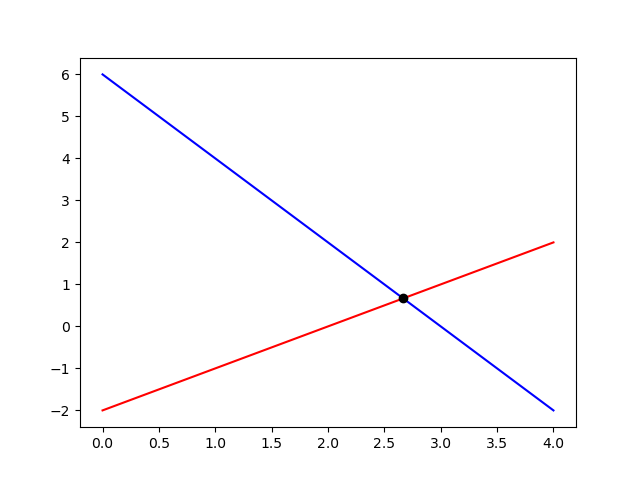

[2.66666667 0.66666667]


In [5]:
# plot the lines for x=[0,4]
x = np.linspace(0, 4, 100)
plt.plot(x, x-2, 'r')
plt.plot(x, -2*x+6, 'b')

# plot the point, first of all convert from homogeneous to Euclidean
pe = p[0:2] / p[2]
print(pe)
plt.plot(pe[0], pe[1], 'ko')

## Parallel lines
Consider two parallel lines $y=x$ and $y=x+1$ which in homogeneous form are
\begin{align}
\ell_1 &= \begin{pmatrix} 1 & -1 & 0\end{pmatrix} \\
\ell_2 &= \begin{pmatrix} 1 & -1 & 1\end{pmatrix}
\end{align}
then their intersection would be 

In [6]:
l1 = np.array([1, -1, 0])
l2 = np.array([1, -1, 1])
p = np.cross(l1, l2)

which we see has its third element equal to zero. This is an ideal point or a point at infinity.  Bottom line, two parallel lines intersect at infinity.  

### Flux Question (1pt)
What is the intersection point of the following 2 lines? l1 and l2
are represented by 2 tuples which are (1, -1, -2) and (1, 1, 1) respectively.

<table>
  <tr>
      <td><div align="left"><font size="20" >Central camera projection model </font></div></td>
  </tr>
</table>

# How to define a camera model

Let's first define some parameters of our camera:
- ``f``: focal length in metres
- ``rho``: pixel side length in metres
- ``u0``: principal point, horizontal coordinate
- ``v0``: principal point, vertical coordinate


Next we define some matrices:
- A 3x3 **intrinsic matrix** (``intrinsic_mat``) that contains information about the camera itself:
  - focal length of the lens
  - pixel size
  - the position of the principal point in units of pixels,this is where the _principal ray_ pierces the image plane.
  
- A 3x4 **projection matrix** (``proj_mat``) that converts 3D world points to 2D image plane points

- A 4x4 **extrinsic matrix** (``extrinsic_mat``) defines how the camera is positioned and oriented in space. We use an identity matrix to place our camera at the world frame origin and looking along the world z-axis.

Finally, we multiply these three matrices together to form the camera matrix (``camera_mat``) of dimensions 3x4

In [7]:
# -------------------- Camera Parameters ---------------------

f = 8*1e-3     # focal length in metres
rho = 10*1e-6  # pixel side length in metres
u0 = 500       # principal point, horizontal coordinate
v0 = 500       # principal point, vertical coordinate

# ----------------------- Matrices -------------------------

intrinsic_mat = np.array([  [f/rho, 0,     u0], 
                [0,     f/rho, v0], 
                [0,     0,     1]])

proj_mat = np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0]])

extrinsic_mat = np.eye(4)
extrinsic_mat[0,-1] = 1 
camera_mat = intrinsic_mat @ proj_mat @ np.linalg.inv(extrinsic_mat)

# Convert 3D points to 2D image plane points

Let's define a set of points in 3D (in homogeneous coordinates) and project them onto the image plane using the camera matrix we just defined.

Remember that the projection will return image plane coordinates in homogeneous form. We need to convert each point to Euclidean coordinates, that is, the 2D image plane coordinates in units of pixels. 


## Convert 2D points homogeneous form to Euclidean coordinates

We can use the helper function ``h2e(.)`` to do so. This function expectes 2D points in homogeneous form and return 2D points Euclidean coordinates



In [8]:
points_3d = np.array([[-1, 0, 5, 1],
                     [ 1, 0, 5, 1],
                     [ 0, math.sqrt(3), 5, 1]]).T

points_2d = camera_mat @ points_3d

points_pixels = h2e(points_2d)
print(points_3d)

[[-1.          1.          0.        ]
 [ 0.          0.          1.73205081]
 [ 5.          5.          5.        ]
 [ 1.          1.          1.        ]]


Let's now visualise these points both in 3D space and in the camera plane

<IPython.core.display.Javascript object>


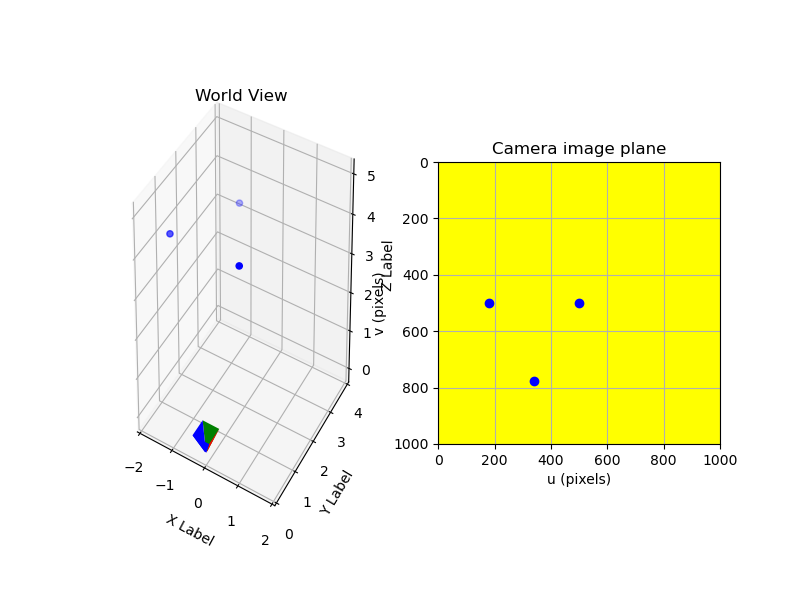

In [9]:
# We create a camera object. This object will help us to plot our camera
camera = Camera(f, rho, (u0, v0))

# We set up the 3D space and 2D plane for camera view
fig = plt.figure(figsize=(8, 6))

# 3D space
ax3d = fig.add_subplot(121, projection='3d')
ax3d.set_xlabel('X Label')
ax3d.set_ylabel('Y Label')
ax3d.set_zlabel('Z Label')
ax3d.set_title('World View')
ax3d.set_xlim(-2,2)
ax3d.set_ylim(0,4)

# 2 plane
ax2d = fig.add_subplot(122)
ax2d.set_xlabel('u (pixels)')
ax2d.set_ylabel('v (pixels)')
ax2d.set_title('Camera image plane')
ax2d.set_aspect('equal')
ax2d.set_facecolor('yellow')
ax2d.set_xlim(0, 1000)
ax2d.set_ylim(1000, 0)  # inverted y-axis
ax2d.grid()

# We plot the polygon that represents our camera
cam_viz = CamVisualizer(camera, f_length=0.5, fb_width=0.05, ft_width=0.5)
collection = Poly3DCollection(cam_viz.gen_frustrum_poly(), facecolors=['g', 'r', 'b', 'b'])
ax3d.add_collection3d(collection)

# Draw points in 3d model
scat3d = ax3d.scatter(points_3d[0], points_3d[1], points_3d[2], c='b')

# Draw points in campera plane
scat2d = ax2d.scatter(points_pixels[0], points_pixels[1], c='b')

### Interact
- Move the 3D points 0.5 meters in each direction, one axis at the time. Observe how their coordinates chage in the camera image plane?

### Flux Question (1pt) :  

Where do the points move to (left or right) when we move the camera 0.5m in the x-axis direction?

*Hint*: Change the top right element of the ``extrinsic_mat`` so as to represent a translation of 0.5m. Recompute the camera matrix project the 3D points onto the camera plane again and see what happens in the figure

<table>
  <tr>
    <td><div align="left"><font size="30" >Image Processing</font></div></td>
  </tr>
</table>

Let's define some helper functions to read, ``iread(relative_path_to_image)``, and display an image ``idisp(image_array)``

In [10]:
# read an image with colors in RGB order for matplotlib
def iread(filename):
    """
    This function reads an image. Only images in the "images" folder are considered

    :param image: str with name of image to be read. 
    :return: a numpy array of size [image_height, image_width] where each [i,j] corresponds to a pixel in the image.
    """
    return cv2.cvtColor(cv2.imread(os.path.join('images', filename)), cv2.COLOR_BGR2GRAY)

# plot the image
def idisp(image, title='Image', small=False, interaction=False, cmap='gray'):
    """
    This function displays an image

    :param image: a numpy array of size [image_height, image_width (each entry corresponds to a pixel in the image)
    :param small: boolean variable indicating preferred size for display
    :param interaction: boolean variable indicating whether we want to display the pixel coordinate and 
                        the grey value of the pixel when cursor drifts over the image
    :param cmap: str that indicites which the colormap used to map scalar data to colors. Possible options are: gray or RdBu
    :return: None
    """
    def mouse_move(self, event, image):
        if event.inaxes and event.inaxes.get_navigate():
            u = int(round(event.xdata))
            v = int(round(event.ydata))
            self.set_message("I[%d, %d] = %d" % (u, v, image[v,u]))
        
    if small:
        fig = plt.figure(figsize=(3,3))
    else:
        fig = plt.figure(figsize=(6,6))
    plt.rcParams['toolbar'] = 'None' 

    plt.imshow(image, cmap, interpolation='none')
    ax = plt.gca()
    plt.grid(True)
    plt.xlabel('u (pixels)')
    plt.ylabel('v (pixels)')
    
    if interaction:
        fig.canvas.toolbar._idDrag = fig.canvas.mpl_connect('motion_notify_event', lambda arg: mouse_move(fig.canvas.toolbar, arg, image))

# Images and pixels
We will start by loading an image

We will use a convenience function to read the image from a PNG format file.  We can load files of different types (with different extensions), eg. `.jpg`

In [11]:
image = iread('monalisa.png')
type(image)

numpy.ndarray

and `image` is a numpy array (a python style matrix) with dimensions

In [12]:
image.shape

(700, 677)

which we see has 700 rows and 677 columns.

The data itself is

In [13]:
image

array([[ 53,  82, 101, ...,  63,  79,  78],
       [ 58,  87,  95, ...,  74,  90,  75],
       [ 68,  86,  83, ...,  85, 100,  72],
       ...,
       [ 12,  16,  12, ...,  11,  10,   8],
       [ 13,  15,  11, ...,  10,   8,   7],
       [ 13,  15,  11, ...,   9,   7,   5]], dtype=uint8)

is simply a big table of 8-bit integers which represent brightness of each pixel as a number between 0 (black) and 1 (white).

We can display it as an image

<IPython.core.display.Javascript object>


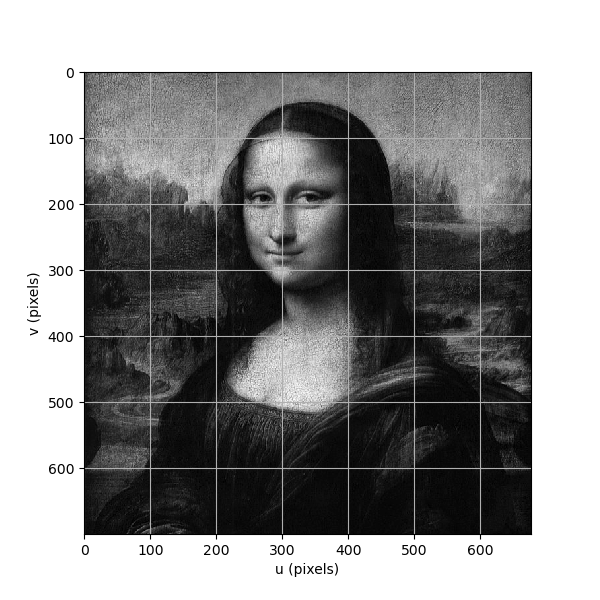

In [14]:
idisp(image)

**The notebook image view is interactive. If you drift your cursor over the image it displays, beneath, the pixel coordinate and the grey value of the pixel.**  

You can turn that feature off by clicking the blue button containin the "power switch" icon.

## Gaussian blur

For image smoothing it is best to use a kernel that is isotropic and symmetric such as a 2D Gaussian
$$G(u,v) = \frac{1}{2\pi\sigma^2}e^{-\frac{u^2+v^2}{2\sigma^2}}$$

<IPython.core.display.Javascript object>


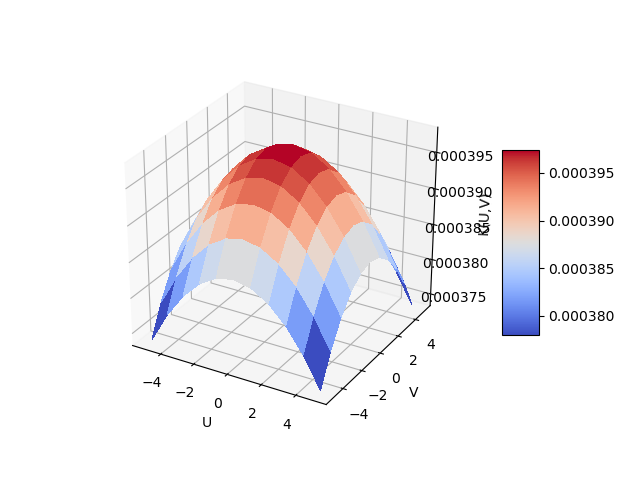

Text(0.5, 0, 'K(U,V)')

In [15]:
w = 5
k = range(-w, w+1)
sigma = 20
[U,V] = np.meshgrid(k, k)
kernel = 1/(2*math.pi*sigma**2)*np.exp(-(U**2+V**2)/(2*sigma**2)) # This is our kernel
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(U, V, kernel, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('U')
ax.set_ylabel('V')
ax.set_zlabel('K(U,V)')

We can blur our image with this kernel

<IPython.core.display.Javascript object>


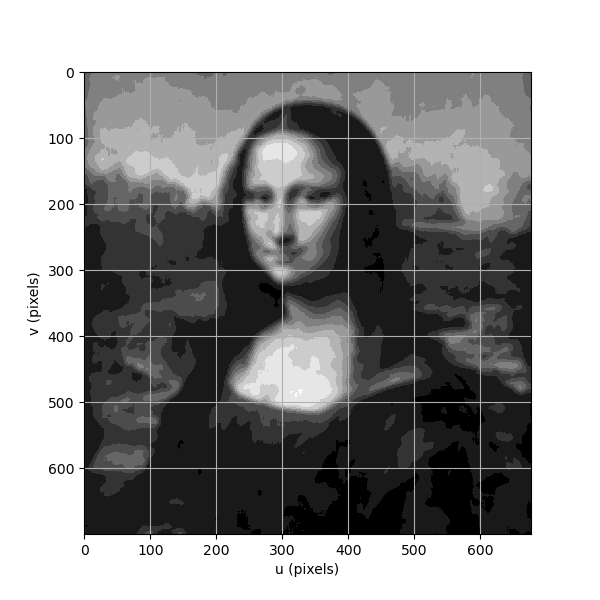

In [16]:
smoothed = cv2.filter2D(image, -1, kernel)
idisp(smoothed)

### Flux Question (1pt)

Increase the sigma value of the kernel to see what effect it has. 

We can do this in a single step where we pass in the image

<IPython.core.display.Javascript object>


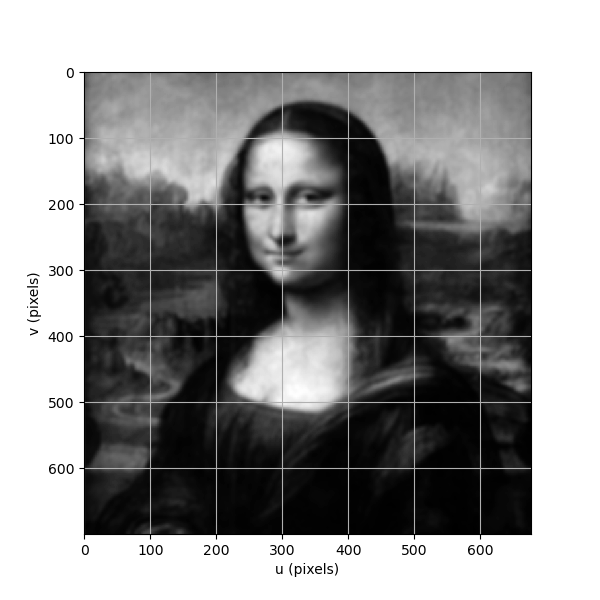

In [17]:
blur = cv2.GaussianBlur(image,(11,11), 3, 3)
idisp(blur)

## Finding edges
We can use 2D filtering to find edges as well.  This convolution kernel will find vertical edges.  The intuition is that each row of this kernel subtracts the pixel to the left from the pixel to the right, which will give a positive value if the intensity is increasing left to right.
<p style="border:3px; border-style:solid; border-color:#FF0000; padding: 1em;">You may often see this filter kernel written with the first and third columns swapped.  The function filter2D performs correlation, not convolution. These are two similar operations but differ in the kernel being transposed.</p>



In [30]:
kernel = np.array( [ [-1, 0, 1],
                     [-2, 0, 2],
                     [-1, 0, 1] ]) / 8
kernel = np.array( [ [1, 1, 1],
                     [2, 2, 2],
                     [1, 1, 1] ]) / 8
# kernel = np.array( [ [-1, -2, -1],
#                      [0, 0, 0],
#                      [1, 2, 1] ]) / 8

<IPython.core.display.Javascript object>


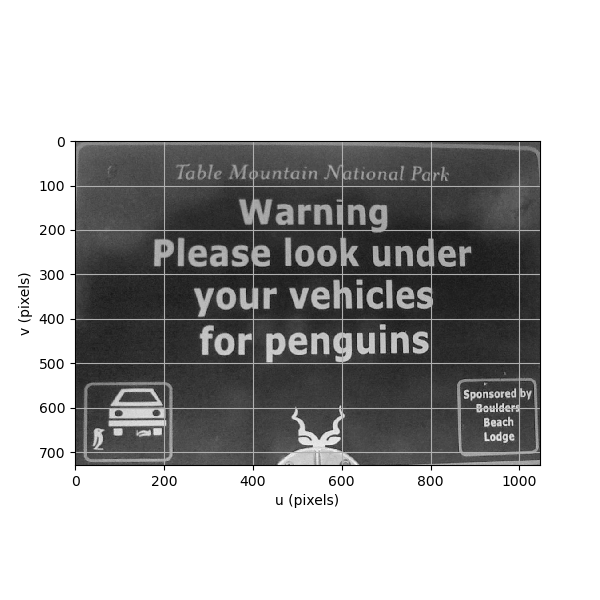

In [31]:
image = iread('penguins.png')
idisp(image)

<IPython.core.display.Javascript object>


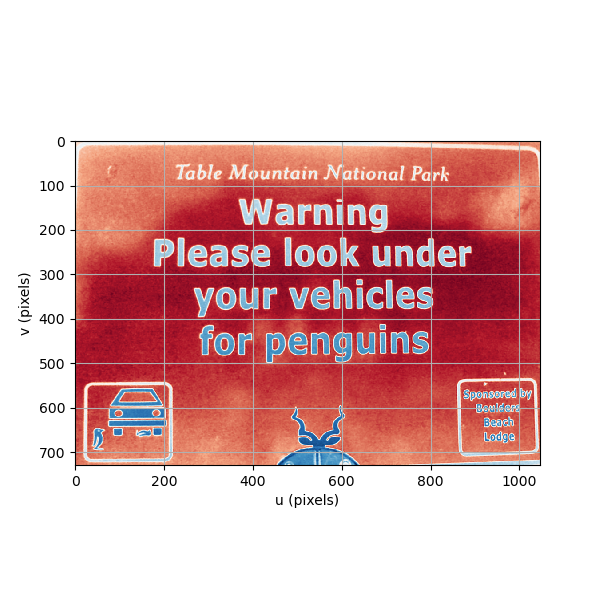

In [32]:
edgy = cv2.filter2D(image, cv2.CV_32F, kernel)
idisp(edgy, cmap='RdBu')                

The image is displayed with a color map that shows negative numbers as red and positive numbers as blue.  Zoom in on the outline of the "T" (use the second button from the right) and you can see that the intensity goes up (blue) on the left of the stem of the "T", from the grey background to the white paint. It goes down (red) on right of the stem, from the white paint to the gray background.

<p style="border:3px; border-style:solid; border-color:#FF0000; padding: 1em;">Note that we tell filter2D to output a signed floating point image.  The result, at each pixel, can be positive or negative.  By default the output image will be the same as the input image (signalled by the -1 second argument used in previous examples) but that cannot represent negative numbers.  In the land of 8-bit unsigned numbers 6-4=2 but 4-6=0.</p>

### Flux Question (1pt)
Write the code of computing horizontal edges of the image.

In [ ]:
# Add your code here

<table>
  <tr>
    <td><div align="left"><font size="10" >Coding Exercise (6 pts)</font></div></td>
  </tr>
</table>

Implement your own convolution operation with an image you chose (from the images folder) using numpy operations rather than just calling opencv methods. 

### TODO:

To complete this exercise, please fill the missing code in the ``convolve_image(.)`` method. This method has as parameters:
- ``image_name (str)``: the name of the image you want to convolve (**make sure to use an image in the images folder or to add any image of your choice to that folder**)
- ``my_kernel (np.array)``: 3x3 np.array specifying the convolution kernel to be used

You should return a nxm np.array with the convolved image, where n = image width and m = image height.

### Keep in mind:

- Flip the kernel: Non-symmetric kernels have to be flipped both around its horizontal and vertical axis before calculating the convolution 
- Pad your image: Add a zero padding to the image being convoluted so you will not run into dimensionality issues.

### For grading: 
- Please make sure that your function receives and returns the expected variables and types. If you change the function's signature, your code will fail to run with the test parameters specified by the grading tool and you will be assigned 0 pts
- Do not include any ``print(.)`` statement inside the function being graded
- Make sure your code runs. Otherwise, the grading tool will take any execution error as an incorrect answer and you will be assigned 0 pts.
- If you do not follow the naming convention **[StudentID]_Practical05.ipynb**, your code will not be graded and  you will be assigned 0 pts.

In [ ]:
def convolve_image(image_name="", my_kernel=None):
        
    """
    This function which takes an image_name and a kernel and returns the convolution of them.

    :param image: str with name of image to be used for convolution. 
                  If a name is not provided, a dummy array will be used as image instead
    
    :param kernel: a numpy array of size [kernel_height, kernel_width].
                   If no kernel is provided, a 3x3 identity matrix will be defined as kernel
    :return: a numpy array of size [image_height, image_width] (convolution output).
    """
    
    # Define a dummy matrix in case image_name is not provided
    image = np.arange(100).reshape(10,10)
    
    # We read the image
    if image_name != "":
        image = iread(image_name)
        
    # Define dummy kernel if my_kernel is not provided        
    if my_kernel is None:
        my_kernel = np.eye(3)
        
    # convolution output
    conv_image = np.zeros_like(image)
        
    # ------------------------------- Add your code here ----------------------
    
    
    # -------------------------------------------------------------------------
    

    return conv_image

## Test your solution numerically

You can verify your implementation numerically by comparing your output with to the test cases provided below. The test cases use the dummy array internally specified by the ``convolve_image(.)`` when no image file name is provided

In [ ]:
# Read test cases from pickle file
with open('common/conv_test_cases.pk', 'rb') as my_file:
    test_cases = pickle.load(my_file)
    
# Run each case and compare outputs
for i, case in enumerate(test_cases):
    # Get kernel used in test case
    test_kernel = case['kernel']
    # Get expected output
    expected_output = case['output']
    # Generate output using your implementation
    your_output = convolve_image(image_name="", my_kernel=test_kernel)
    
    
    if not np.all(np.isclose(expected_output, your_output)):
        print("You have failed test case {}/{}. Please revise your implementation".format(i+1, 
                                                                                          len(test_cases)))
        break
    else:
        print("You have passed test {}/{}".format(i+1, len(test_cases)))
        


## Test your solution visually

You can verify your implementation visually by comparing your output with the one generated by python library **scipy**.

In [ ]:
# We define the kernel we want to use
kernel = np.array([[0.,1.,0.], [1.,1.,1.], [0.,1.,0.]])

# Specify the image path
image_file = 'penguins.png'

# Call your function
my_result = convolve_image(image_file, kernel)

# Display the output
idisp(my_result, cmap='RdBu')

In [ ]:
# We use scipy to do the convultion automatically for us

# Load the required library
from scipy import ndimage

# Apply the convolution
original_image = iread(image_file)
output = ndimage.convolve(original_image, kernel, mode='constant', cval=0.0)

# Display the output
idisp(output, cmap='RdBu')